# Sommaire
* [Introduction](#introduction)
* [I) Importation et nettoyage des données](#i)
* [II) Exports](#ii)
* [III) Tracking MLFlow](#iii)
    * [1) Régression logistique](#iii1)
    * [2) LightGBM](#iii2)

# Introduction <a class="anchor" id="introduction"></a>
La société financière Prêt à dépenser souhaite mettre en oeuvre un outil de scoring crédit pour calculer la probabilité qu'un client rembourse son crédit, afin d'accorder ou non ledit crédit. Elle souhaite donc développer un algorithme de classification en s'appuyant sur des données comportementales ainsi que des données provenant d'autres institutions financières.

Dans ce notebook, nous nous focaliserons d'abord sur le nettoyage des données, ainsi que l'analyse exploratoire.

Ensuite, nous enchaînerons sur l'entraînement des modèles et le tracking MLFlow. La librairie MLFlow va nous permettre de logger les paramètres des modèles, les métriques, le temps d'entraînement ainsi que les modèles eux-mêmes. Nous utiliserons l'AUC (Area Under Curve) et le recall pour affiner les hyperparamètres de nos modèles. En effet, comme on cherche à minimiser le nombre de faux négatifs, le recall est la métrique la plus pertinente à suivre.

Nous testerons deux modèles : Une régression logistique (linéaire) et LightGBM (une version plus légère de XGBoost, non linéaire). Comme notre dataset contient des NaNs, il conviendra de procéder à une imputation avant la régression logistique. En revanche, LightGBM fonctionne bien sur des données qui contiennent des NaNs, on n'aura donc pas besoin de dénaturer le dataset avec une imputation.

Attention toutefois :
 - Au déséquilibre entre le nombre de bons et de moins bons clients.
 - Au déséquilibre du coût métier entre un faux négatif et un faux positif. On estime que le coût d'un faux négatif est 10 fois supérieur au coût d'un faux positif. D'où la création d'un score "métier" dans le but de minimiser le coût d'erreur de prédiction. **Cela veut dire qu'un bon score métier est un score faible**. Ce score permettra de choisir le meilleur modèle et ses meilleurs hyperparamètres.
 - Au seuil de détermination des classes. Toujours dans l'optique de minimiser le score métier, "predict" suppose un seuil à 0.5, qui ne sera pas forcément optimal.
 - Au score de l'AUC, un score supérieur à 0.82 (score du vainqueur du challenge Kaggle) pourrait suggérer de l'overfitting.

# I) Importation et nettoyage des données <a class="anchor" id="i"></a>
Ce jeu de données venant d'un challenge Kaggle, nous avons la chance de pouvoir nous inspirer du kernel d'un participant qui s'est focalisé sur la partie nettoyage de données et jointures, et ainsi gagner beaucoup de temps en vue de l'analyse exploratoire. Je détaille les étapes réalisées dans le bloc ci-dessous.

In [1]:
import numpy as np
import pandas as pd
import gc #Le "ramasse-miettes", après avoir supprimé des objets volumineux, permet de s'assurer que la mémoire qui leur était allouée est bien récupérée
import time
from contextlib import contextmanager #Permet de centraliser la logique d'ouverture/fermeture ou d'aquisition/libération d'une ressource de manière propre et concise
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#On définit une fonction qui sera utilisée dans toutes les fonctions suivantes pour one-hot encoder les variables catégorielles avec get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

#On définit une fonction à appliquer sur application_train.csv et application_test.csv, les 2 tables principales
#Elles contiennent des informations sur les demandes de crédit des emprunteurs
def application_train_test(num_rows = None, nan_as_category = False):
    #On importe et concatène
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df,test_df]).reset_index(drop=True)
    #Il existe 4 lignes dans le jeu d'entraînement avec un CODE_GENDER qui vaut XNA, on les retire
    df = df[df['CODE_GENDER'] != 'XNA']
    
    #Encodage binaire pour ces 3 variables
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    #Le fameux one-hot encoder appliqué sur le reste des variables catégorielles
    #L'argument nan_as_category permet de traiter les NaNs comme une catégorie à part entière lors de l'encodage
    #Cela signifie qu'on créé une nouvelle colonne spécifique au lieu de les ignorer ou de tenter une imputation hasardeuse
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    #Certaines lignes ont une valeur de 365243 dans la colonne DAYS_EMPLOYED
    #Ca correspond à 100 ans, c'est impossible donc on remplace par des NaNs
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    #Ajout de nouvelles features
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'] #Pourcentage de jours travaillés par rapport à l'âge de l'emprunteur
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT'] #Ratio entre le revenu total de l'emprunteur et le montant du crédit demandé
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'] #Revenu par personne dans la famille de l'emprunteur
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'] #Pourcentage de revenu total consacré au remboursement de l'annuité
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] #Montant de l'annuité par rapport au montant total du crédit
    del test_df
    gc.collect()
    return df

#On définit une fonction à appliquer sur les tables bureau.csv et bureau_balance.csv
#Ces tables contiennent des informations sur les antécédents de crédit des emprunteurs auprès d'autres institutions financières, y compris les prêts en cours (on va y revenir)
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    #Pas de variables catégorielles binaires ici, alors on one-hot encode tout
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    #On effectue des opérations d'agrégations sur bureau_balance.csv et on merge avec bureau.csv
    #Concrètement, on créé 3 colonnes à partir de la colonne MONTHS_BALANCE (min, max et size)
    #Ensuite on calcule la moyenne des autres colonnes (ici les colonnes one-hot encodées de STATUS)
    #Cela permet de conserver un maximum d'informations tout en ayant une seule ligne par crédit
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()]) #Pour passer les informations concernant l'opération d'agrégation dans le nom de la colonne
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU') #Jointure avec bureau.csv
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    #Même démarche que précédemment, seulement sur plus de colonnes numériques
    #C'est nécessaire car un emprunteur peut avoir eu plusieurs crédits, or là on souhaite avoir une ligne par emprunteur et non par crédit
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    #Cela signifie qu'au niveau des variables catégorielles one-hot encodées de bureau_balance.csv, on va calculer la moyenne des moyennes précédemment calculées (si si)
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()]) #Pour passer les informations concernant l'opération d'agrégation dans le nom de la colonne

    #On créé de nouvelles variables en se focalisant exclusivement sur les crédits actifs
    #Elles donnent une idée de l'engagement financier actuel de l'emprunteur
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    #Idem avec les crédits fermés
    #Elles permettent d'évaluer l'historique des remboursements de l'emprunteur
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

#On enchaîne avec previous_applications.csv
#Cette table contient des informations sur les demandes de crédit précédentes des emprunteurs auprès de Home Credit directement, acceptées ou refusées
#Globalement même démarche que ci-dessus, souhaite une ligne par emprunteur donc on agrège
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    #On retrouve ici certaines lignes qui ont une valeur de 365243 (encore ?!) dans plusieurs colonnes
    #On remplace à nouveau par des NaNs
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    #Ajout d'une nouvelle feature
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT'] #Rapport entre le montant demandé par l'emprunteur et le montant approuvé du crédit
    
    #Agrégations
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    cat_aggregations = {}
    for cat in cat_cols: cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    #On créé de nouvelles variables en se focalisant exclusivement sur les demandes approuvées
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    #Idem avec les demandes refusées
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

#On enchaîne avec POS_CASH_balance.csv
#Cette table permet de suivre l'historique des paiements dus sur les crédits
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

    #Agrégations
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols: aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    #Ajout d'une nouvelle feature
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size() #Durée de l'activité de crédit de l'emprunteur
    del pos
    gc.collect()
    return pos_agg
    
#On enchaîne avec installments_payments.csv
#Cette table contient des informations sur les montants des mensualités et les paiements réels effectués par les emprunteurs
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    #Ajout de features
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT'] #Pourcentage du montant payé par rapport à la mensualité
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT'] #Différence entre le montant de la mensualité et le montant payé
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT'] #Jours de retard du paiement
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT'] #Jours d'avance du paiement
    #Pour s'assurer que les 2 dernières features soient toujours positives
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    #Agrégations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols: aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    #Ajout d'une nouvelle feature
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size() #Nombre de paiements effectués
    del ins
    gc.collect()
    return ins_agg

#On termine avec credit_card_balance.csv
#Cette table contient des informations sur les transactions et soldes de cartes de crédit pour chaque emprunteur
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)

    #Agrégation sur toutes les colonnes (hors SK_ID_CURR)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    #Ajout d'une feature
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size() #Nombre d'événements enregistrés dans l'historique de chaque emprunteur
    del cc
    gc.collect()
    return cc_agg

#On centralise tout ça
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

with timer("Full model run"):
    df = main()
    
df

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 23s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 31s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26)
Process installments payments - done in 30s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 18s
Full model run - done in 124s


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
#Recherche de valeurs infinies (positives et négatives)
inf_count = (df == np.inf).sum().sum()
print(f"Nombre de valeurs +inf : {inf_count}")

neg_inf_count = (df == -np.inf).sum().sum()
print(f"Nombre de valeurs -inf : {neg_inf_count}")

Nombre de valeurs +inf : 21
Nombre de valeurs -inf : 0


In [3]:
#On va les remplacer par des NaNs
df.replace(np.inf, np.nan, inplace=True)

#On vérifie qu'on en a bien 0
print("Nombre de valeurs +inf : ", (df == np.inf).sum().sum())

Nombre de valeurs +inf :  0


In [4]:
#On isole les colonnes n'ayant qu'une seule valeur unique
valeur_unique = [col for col in df.columns if df[col].nunique() == 1]
print("Nombre de colonnes à valeur unique : ", len(valeur_unique))
print()
valeur_unique

Nombre de colonnes à valeur unique :  27



['BURO_CREDIT_ACTIVE_nan_MEAN',
 'BURO_CREDIT_CURRENCY_nan_MEAN',
 'BURO_CREDIT_TYPE_nan_MEAN',
 'BURO_STATUS_nan_MEAN_MEAN',
 'PREV_NAME_CONTRACT_TYPE_nan_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN',
 'PREV_NAME_CONTRACT_STATUS_nan_MEAN',
 'PREV_NAME_PAYMENT_TYPE_nan_MEAN',
 'PREV_CODE_REJECT_REASON_nan_MEAN',
 'PREV_NAME_CLIENT_TYPE_nan_MEAN',
 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
 'PREV_NAME_PORTFOLIO_nan_MEAN',
 'PREV_NAME_PRODUCT_TYPE_nan_MEAN',
 'PREV_CHANNEL_TYPE_nan_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN',
 'PREV_NAME_YIELD_GROUP_nan_MEAN',
 'POS_NAME_CONTRACT_STATUS_nan_MEAN',
 'CC_NAME_CONTRACT_STATUS_Approved_MIN',
 'CC_NAME_CONTRACT_STATUS_Refused_MIN',
 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN',
 'CC_NAME_CONTRACT_STATUS_nan_MIN',
 'CC_NAME_CONTRACT_STATUS_nan_MAX',
 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
 'CC_NAME_CONTRACT_STATUS_nan_SUM',
 'CC_NAME_CONTRACT_STATUS_nan_VAR']

In [5]:
#Ces colonnes n'apporteront rien à l'analyse alors on les drop
df.drop(columns=valeur_unique, inplace=True)

In [6]:
#On met désormais à part les données de test, comme la target n'est pas renseignée, on ne s'en servira pas pour l'entraînement des modèles
#En revanche, on s'en servira pour le data drift donc on les conserve tout de même
data_test = df[df['TARGET'].isna()]
print(data_test.shape)
display(data_test[:5])
print()

data_final = df.dropna(subset=['TARGET'])
print(data_final.shape)
display(data_final[:5])

(48744, 770)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
307511,100001,NaN,1,0,0,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307512,100005,NaN,0,0,0,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307513,100013,NaN,0,1,0,0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0
307514,100028,NaN,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0
307515,100038,NaN,0,1,1,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



(307507, 770)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# II) Exports <a class="anchor" id="ii"></a>
Les données sont prêtes pour l'entraînement des modèles (et plus tard, le data drift).

In [7]:
data_final.to_parquet('./Veynachter_Quentin_3_Dossier_Code_112023/Artefacts/data_final.parquet', index=False)
data_test.to_parquet('./Veynachter_Quentin_3_Dossier_Code_112023/Artefacts/data_test.parquet', index=False)

# III) Tracking MLFlow <a class="anchor" id="iii"></a>

In [8]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('./Veynachter_Quentin_3_Dossier_Code_112023/Artefacts/data_final.parquet')
df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307503,456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307504,456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307505,456254,1.0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


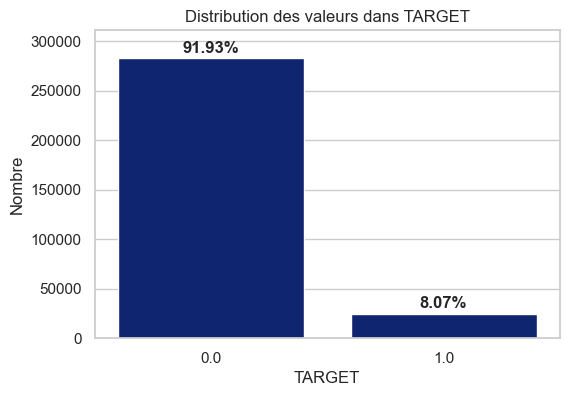

In [2]:
#Visualisation du déséquilibre entre bons et mauvais clients
target_counts = df['TARGET'].value_counts()

#Calcul des pourcentages
total = len(df)
percentages = target_counts / total * 100

#Barplot
sns.set_theme(style="whitegrid", palette="dark")
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=target_counts.index, y=target_counts.values)

#Ajout des pourcentages en annotations
for i, v in enumerate(target_counts.values):
    ax.text(i, v + 0.02*max(target_counts.values), f'{percentages[i]:.2f}%', ha='center', fontweight='bold')

#On augmente un peu l'espace en haut du plot pour faire place aux annotations
plt.ylim(0, max(target_counts.values) * 1.1) #10% d'espace

#Titres et labels
ax.set_xlabel('TARGET')
ax.set_ylabel('Nombre')
ax.set_title('Distribution des valeurs dans TARGET')

plt.show()

In [3]:
#Gros déséquilibre de distribution
#Rappel que 0 représente les bons clients et 1 les moins bons clients
#On créé un nouveau df où on remplace les valeurs manquantes par la moyenne
df_nona = df.fillna(df.mean())
df_nona

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,6.000000
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
307503,456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
307504,456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
307505,456254,1.0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605


## 1) Régression logistique <a class="anchor" id="iii1"></a>
On utilise la librairie optuna car elle utilise une approche de recherche d'hyperparamètres appelée **optimisation bayésienne**. Au lieu de tester toutes les combinaisons possibles (comme GridSearchCV), optuna échantillonne les valeurs de manière adaptative, en se basant sur les performances des essais précédents, ce qui permet de converger plus rapidement vers des solutions optimales.

In [3]:
pip install optuna

  Using cached Mako-1.3.6-py3-none-any.whl.metadata (2.9 kB)
Using cached Mako-1.3.6-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import gc
import time
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import optuna
from datetime import timedelta

#Début du timer
start_time = time.time()

#On définit le chemin où seront enregistrées les runs
mlflow.set_tracking_uri('./Veynachter_Quentin_3_Dossier_Code_112023/mlruns')

#Configuration initiale de MLFlow
mlflow.set_experiment('Logistic_regression')

#On sépare en X et y
X = df_nona.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_nona['TARGET']

#Centrage et réduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Validation croisée stratifiée (pour tenir compte du déséquilibre de distribution) et définition des poids
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
poids_classes = {0: 1, 1: target_counts.get(0) / target_counts.get(1)}

#Signature basée sur les données d'entrée et de sortie
signature = infer_signature(X_scaled, y)

#Liste vide pour enregistrer les résultats
resultats = []

#Nombre de combinaisons à tester
combinaisons_max = 50

#On définit une fonction pour l'optimisation des hyperparamètres
def objective(trial):
    params ={'C' : trial.suggest_float('C', 0.01, 200, log=True),
             'penalty' : trial.suggest_categorical('penalty', [None, 'l1', 'l2'])}
    threshold = trial.suggest_float('threshold', 0.05, 0.95)
    #Le modèle
    #Le solver saga est le seul compatible avec toutes les pénalités que nous essayons, de plus il est particulièrement adapté aux grands datasets
    #tol=0.01 aide à converger plus rapidement
    model = LogisticRegression(**params, solver='saga', tol=0.01, max_iter=1000, class_weight=poids_classes, random_state=42, verbose=0)
    
    #On fit avec timer
    start_fit_time = time.time()
    y_prob = cross_val_predict(model, X_scaled, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1] #[:, 1] parce qu'on est intéressé par le nombre de 1 prédits
    fit_time = time.time() - start_fit_time
    fit_time = str(timedelta(seconds=int(fit_time)))

    #On prédit le nombre de 0 en fonction du threshold
    y_pred = y_prob > threshold

    #Métriques
    auc = roc_auc_score(y, y_prob)
    rec = recall_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel() #Pour aplatir la matrice
    score = fp + 10 * fn #Score métier
    
    #On enregistre les résultats
    resultats.append({**params,
                      'Threshold': threshold,
                      'AUC': auc,
                      'Recall': rec,
                      'Score métier': score,
                      'Fit time': fit_time})

    #On démarre l'exécution dans MLFlow
    with mlflow.start_run():
        #On enregistre les params, métriques et temps de fit
        mlflow.log_params(params)
        mlflow.log_param('Threshold', threshold)
        mlflow.log_metric('AUC', auc)
        mlflow.log_metric('Recall', rec)
        mlflow.log_metric('Score métier', score)
        mlflow.log_param('Fit time', fit_time) #Techniquement c'est une métrique, mais comme elle est au format str, log_metric ne la prend pas

        #Courbe ROC
        tfp, tvp, _ = roc_curve(y, y_prob)
        plt.figure(figsize=(10, 7))
        plt.plot(tfp, tvp, label=f'AUC: {auc:.2f}')
        plt.title('Courbe_ROC')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.legend(loc='lower right')
        plt.savefig('courbe_roc.png')
        plt.close()
        mlflow.log_artifact('courbe_roc.png')

        #On enregistre le modèle
        mlflow.sklearn.log_model(model, 'Logistic_regression', signature=signature)

    gc.collect()
    return score

#On définit une fonction pour suivre la progresion des essais d'optimisation
def print_progress(study, trial, combinaisons_max):
    print(f'Essai {trial.number + 1}/{combinaisons_max} terminé !', flush=True)

#Comme mentionné plus haut, on souhaite minimiser le score métier
study = optuna.create_study(direction='minimize')

#On applique
study.optimize(objective, n_trials=combinaisons_max, callbacks=[lambda study, trial: print_progress(study, trial, combinaisons_max)])

#On transforme les résultats en df
resultats_df = pd.DataFrame(resultats)

#Fin du timer
end_time = time.time()
temps_total = end_time - start_time
temps_total = timedelta(seconds=int(temps_total))
print()
print('Temps total :', temps_total)
print()

#Les meilleurs params
print(study.best_params)

2024/12/02 17:44:02 INFO mlflow.tracking.fluent: Experiment with name 'Logistic_regression' does not exist. Creating a new experiment.
[I 2024-12-02 17:44:11,698] A new study created in memory with name: no-name-c4f3df44-fc64-4867-899e-d097ce1fa796
[I 2024-12-02 17:50:09,379] Trial 0 finished with value: 203606.0 and parameters: {'C': 58.48173218725117, 'penalty': 'l2', 'threshold': 0.7927681826176566}. Best is trial 0 with value: 203606.0.


Essai 1/50 terminé !


[I 2024-12-02 17:54:44,984] Trial 1 finished with value: 157605.0 and parameters: {'C': 19.607284220170666, 'penalty': 'l1', 'threshold': 0.5296347288274744}. Best is trial 1 with value: 157605.0.


Essai 2/50 terminé !


[I 2024-12-02 17:56:50,278] Trial 2 finished with value: 210709.0 and parameters: {'C': 82.38914169724607, 'penalty': None, 'threshold': 0.8155843325022377}. Best is trial 1 with value: 157605.0.


Essai 3/50 terminé !


[I 2024-12-02 18:00:38,474] Trial 3 finished with value: 188057.0 and parameters: {'C': 0.08222316807634493, 'penalty': 'l1', 'threshold': 0.31462662843640327}. Best is trial 1 with value: 157605.0.


Essai 4/50 terminé !


[I 2024-12-02 18:04:38,089] Trial 4 finished with value: 208519.0 and parameters: {'C': 2.5215962502329305, 'penalty': 'l1', 'threshold': 0.25449103565600095}. Best is trial 1 with value: 157605.0.


Essai 5/50 terminé !


[I 2024-12-02 18:06:40,254] Trial 5 finished with value: 168423.0 and parameters: {'C': 0.041341609555263954, 'penalty': 'l2', 'threshold': 0.6465506656568908}. Best is trial 1 with value: 157605.0.


Essai 6/50 terminé !


[I 2024-12-02 18:08:41,670] Trial 6 finished with value: 172045.0 and parameters: {'C': 0.5696469131507531, 'penalty': 'l2', 'threshold': 0.3806601718590672}. Best is trial 1 with value: 157605.0.


Essai 7/50 terminé !


[I 2024-12-02 18:10:45,413] Trial 7 finished with value: 226379.0 and parameters: {'C': 97.22717044308357, 'penalty': 'l2', 'threshold': 0.2084689536424319}. Best is trial 1 with value: 157605.0.


Essai 8/50 terminé !


[I 2024-12-02 18:12:47,092] Trial 8 finished with value: 244590.0 and parameters: {'C': 8.587281055626796, 'penalty': None, 'threshold': 0.940345352522405}. Best is trial 1 with value: 157605.0.


Essai 9/50 terminé !


[I 2024-12-02 18:14:46,613] Trial 9 finished with value: 182463.0 and parameters: {'C': 1.235722166473409, 'penalty': 'l2', 'threshold': 0.3354350018815438}. Best is trial 1 with value: 157605.0.


Essai 10/50 terminé !


[I 2024-12-02 18:18:51,038] Trial 10 finished with value: 273857.0 and parameters: {'C': 13.509736445442318, 'penalty': 'l1', 'threshold': 0.07950737476792302}. Best is trial 1 with value: 157605.0.


Essai 11/50 terminé !


[I 2024-12-02 18:22:20,718] Trial 11 finished with value: 161976.0 and parameters: {'C': 0.01813831776198829, 'penalty': 'l1', 'threshold': 0.6081734311182907}. Best is trial 1 with value: 157605.0.


Essai 12/50 terminé !


[I 2024-12-02 18:25:53,884] Trial 12 finished with value: 158393.0 and parameters: {'C': 0.01693552068553262, 'penalty': 'l1', 'threshold': 0.5634174123918209}. Best is trial 1 with value: 157605.0.


Essai 13/50 terminé !


[I 2024-12-02 18:29:48,948] Trial 13 finished with value: 157633.0 and parameters: {'C': 0.1946142440872025, 'penalty': 'l1', 'threshold': 0.510711784154518}. Best is trial 1 with value: 157605.0.


Essai 14/50 terminé !


[I 2024-12-02 18:33:44,774] Trial 14 finished with value: 161289.0 and parameters: {'C': 0.2415034829380202, 'penalty': 'l1', 'threshold': 0.44541473841072915}. Best is trial 1 with value: 157605.0.


Essai 15/50 terminé !


[I 2024-12-02 18:37:45,538] Trial 15 finished with value: 157542.0 and parameters: {'C': 10.44034752240568, 'penalty': 'l1', 'threshold': 0.5270654558724349}. Best is trial 15 with value: 157542.0.


Essai 16/50 terminé !


[I 2024-12-02 18:41:49,338] Trial 16 finished with value: 174589.0 and parameters: {'C': 16.60371562909737, 'penalty': 'l1', 'threshold': 0.6804418051320369}. Best is trial 15 with value: 157542.0.


Essai 17/50 terminé !


[I 2024-12-02 18:43:49,488] Trial 17 finished with value: 161207.0 and parameters: {'C': 4.782937855040551, 'penalty': None, 'threshold': 0.4463343555730771}. Best is trial 15 with value: 157542.0.


Essai 18/50 terminé !


[I 2024-12-02 18:47:50,309] Trial 18 finished with value: 184903.0 and parameters: {'C': 30.231776091972325, 'penalty': 'l1', 'threshold': 0.7258920367787937}. Best is trial 15 with value: 157542.0.


Essai 19/50 terminé !


[I 2024-12-02 18:51:56,171] Trial 19 finished with value: 157723.0 and parameters: {'C': 3.4730015456925463, 'penalty': 'l1', 'threshold': 0.531665309308167}. Best is trial 15 with value: 157542.0.


Essai 20/50 terminé !


[I 2024-12-02 18:54:25,442] Trial 20 finished with value: 249107.0 and parameters: {'C': 192.0632652467704, 'penalty': None, 'threshold': 0.15296402859163677}. Best is trial 15 with value: 157542.0.


Essai 21/50 terminé !


[I 2024-12-02 18:58:30,272] Trial 21 finished with value: 158359.0 and parameters: {'C': 0.26140727231116223, 'penalty': 'l1', 'threshold': 0.47857024214711147}. Best is trial 15 with value: 157542.0.


Essai 22/50 terminé !


[I 2024-12-02 19:02:31,358] Trial 22 finished with value: 157969.0 and parameters: {'C': 0.7947396849765404, 'penalty': 'l1', 'threshold': 0.555809662894108}. Best is trial 15 with value: 157542.0.


Essai 23/50 terminé !


[I 2024-12-02 19:06:34,006] Trial 23 finished with value: 160402.0 and parameters: {'C': 6.4763151495891265, 'penalty': 'l1', 'threshold': 0.45068618585180875}. Best is trial 15 with value: 157542.0.


Essai 24/50 terminé !


[I 2024-12-02 19:10:54,517] Trial 24 finished with value: 170423.0 and parameters: {'C': 28.175517700633694, 'penalty': 'l1', 'threshold': 0.3877631350830876}. Best is trial 15 with value: 157542.0.


Essai 25/50 terminé !


[I 2024-12-02 19:15:02,250] Trial 25 finished with value: 160944.0 and parameters: {'C': 0.16275094903491394, 'penalty': 'l1', 'threshold': 0.5937977764899037}. Best is trial 15 with value: 157542.0.


Essai 26/50 terminé !


[I 2024-12-02 19:19:15,237] Trial 26 finished with value: 172373.0 and parameters: {'C': 1.997439602007551, 'penalty': 'l1', 'threshold': 0.6679571700664184}. Best is trial 15 with value: 157542.0.


Essai 27/50 terminé !


[I 2024-12-02 19:23:11,139] Trial 27 finished with value: 157641.0 and parameters: {'C': 0.4197606348861592, 'penalty': 'l1', 'threshold': 0.5091287181442503}. Best is trial 15 with value: 157542.0.


Essai 28/50 terminé !


[I 2024-12-02 19:25:13,935] Trial 28 finished with value: 187251.0 and parameters: {'C': 0.07930383591113255, 'penalty': None, 'threshold': 0.7354933855111394}. Best is trial 15 with value: 157542.0.


Essai 29/50 terminé !


[I 2024-12-02 19:29:16,393] Trial 29 finished with value: 200383.0 and parameters: {'C': 42.44681383446097, 'penalty': 'l1', 'threshold': 0.7825788693432292}. Best is trial 15 with value: 157542.0.


Essai 30/50 terminé !


[I 2024-12-02 19:31:19,672] Trial 30 finished with value: 171406.0 and parameters: {'C': 10.922585656262635, 'penalty': 'l2', 'threshold': 0.38324661559627704}. Best is trial 15 with value: 157542.0.


Essai 31/50 terminé !


[I 2024-12-02 19:35:20,926] Trial 31 finished with value: 157474.0 and parameters: {'C': 0.37527341675745984, 'penalty': 'l1', 'threshold': 0.5275263398569278}. Best is trial 31 with value: 157474.0.


Essai 32/50 terminé !


[I 2024-12-02 19:39:17,498] Trial 32 finished with value: 157678.0 and parameters: {'C': 0.0929261537580304, 'penalty': 'l1', 'threshold': 0.5083799612165147}. Best is trial 31 with value: 157474.0.


Essai 33/50 terminé !


[I 2024-12-02 19:43:21,651] Trial 33 finished with value: 162901.0 and parameters: {'C': 1.3047979068273623, 'penalty': 'l1', 'threshold': 0.614537905761018}. Best is trial 31 with value: 157474.0.


Essai 34/50 terminé !


[I 2024-12-02 19:47:21,371] Trial 34 finished with value: 190325.0 and parameters: {'C': 82.86406291413842, 'penalty': 'l1', 'threshold': 0.30715496613679694}. Best is trial 31 with value: 157474.0.


Essai 35/50 terminé !


[I 2024-12-02 19:51:09,147] Trial 35 finished with value: 165165.0 and parameters: {'C': 0.05210136689197416, 'penalty': 'l1', 'threshold': 0.41386984421909934}. Best is trial 31 with value: 157474.0.


Essai 36/50 terminé !


[I 2024-12-02 19:55:07,461] Trial 36 finished with value: 224264.0 and parameters: {'C': 0.6683243824156566, 'penalty': 'l1', 'threshold': 0.859376497571992}. Best is trial 31 with value: 157474.0.


Essai 37/50 terminé !


[I 2024-12-02 19:57:09,947] Trial 37 finished with value: 157580.0 and parameters: {'C': 0.3265224437312339, 'penalty': None, 'threshold': 0.5413702107688144}. Best is trial 31 with value: 157474.0.


Essai 38/50 terminé !


[I 2024-12-02 19:59:09,573] Trial 38 finished with value: 159693.0 and parameters: {'C': 2.4692363490676277, 'penalty': None, 'threshold': 0.5788396174407052}. Best is trial 31 with value: 157474.0.


Essai 39/50 terminé !


[I 2024-12-02 20:01:13,264] Trial 39 finished with value: 165205.0 and parameters: {'C': 19.480956749593958, 'penalty': None, 'threshold': 0.6283632666495705}. Best is trial 31 with value: 157474.0.


Essai 40/50 terminé !


[I 2024-12-02 20:03:14,794] Trial 40 finished with value: 179927.0 and parameters: {'C': 0.39032472134834567, 'penalty': None, 'threshold': 0.3448115816605557}. Best is trial 31 with value: 157474.0.


Essai 41/50 terminé !


[I 2024-12-02 20:05:15,236] Trial 41 finished with value: 158186.0 and parameters: {'C': 0.19424493510117666, 'penalty': 'l2', 'threshold': 0.47984442952877954}. Best is trial 31 with value: 157474.0.


Essai 42/50 terminé !


[I 2024-12-02 20:07:18,067] Trial 42 finished with value: 158170.0 and parameters: {'C': 0.888970354242901, 'penalty': None, 'threshold': 0.5592367102506117}. Best is trial 31 with value: 157474.0.


Essai 43/50 terminé !


[I 2024-12-02 20:09:21,250] Trial 43 finished with value: 157455.0 and parameters: {'C': 0.12165919973138103, 'penalty': None, 'threshold': 0.5267171274560537}. Best is trial 43 with value: 157455.0.


Essai 44/50 terminé !


[I 2024-12-02 20:11:22,311] Trial 44 finished with value: 178720.0 and parameters: {'C': 0.11109806345823506, 'penalty': None, 'threshold': 0.7000085743417102}. Best is trial 43 with value: 157455.0.


Essai 45/50 terminé !


[I 2024-12-02 20:13:21,825] Trial 45 finished with value: 169044.0 and parameters: {'C': 0.38435558550251975, 'penalty': None, 'threshold': 0.6493143304325416}. Best is trial 43 with value: 157455.0.


Essai 46/50 terminé !


[I 2024-12-02 20:15:24,299] Trial 46 finished with value: 164704.0 and parameters: {'C': 0.025968084660103, 'penalty': None, 'threshold': 0.41659491536025284}. Best is trial 43 with value: 157455.0.


Essai 47/50 terminé !


[I 2024-12-02 20:17:25,537] Trial 47 finished with value: 157439.0 and parameters: {'C': 52.56679734794216, 'penalty': None, 'threshold': 0.5227258673530678}. Best is trial 47 with value: 157439.0.


Essai 48/50 terminé !


[I 2024-12-02 20:19:25,861] Trial 48 finished with value: 157591.0 and parameters: {'C': 170.7295830758564, 'penalty': None, 'threshold': 0.5382155194968478}. Best is trial 47 with value: 157439.0.


Essai 49/50 terminé !


[I 2024-12-02 20:21:28,922] Trial 49 finished with value: 157757.0 and parameters: {'C': 52.44472977898407, 'penalty': None, 'threshold': 0.4894878546276757}. Best is trial 47 with value: 157439.0.


Essai 50/50 terminé !

Temps total : 2:37:26

{'C': 52.56679734794216, 'penalty': None, 'threshold': 0.5227258673530678}


In [8]:
resultats_df.sort_values('Score métier').head(20)

,C,penalty,Threshold,AUC,Recall,Score métier,Fit time
47,52.566797,None,0.522726,0.770937,0.667553,157439,0:01:55
43,0.121659,None,0.526717,0.770937,0.661954,157455,0:01:57
31,0.375273,l1,0.527526,0.770954,0.660665,157474,0:03:53
15,10.440348,l1,0.527065,0.770937,0.661108,157542,0:03:53
37,0.326522,None,0.541370,0.770937,0.641934,157580,0:01:56
48,170.729583,None,0.538216,0.770937,0.646042,157591,0:01:54
1,19.607284,l1,0.529635,0.770937,0.657442,157605,0:04:17
13,0.194614,l1,0.510712,0.770972,0.683061,157633,0:03:49
27,0.419761,l1,0.509129,0.770953,0.685358,157641,0:03:50
32,0.092926,l1,0.508380,0.770979,0.686244,157678,0:03:49


## 2) LightGBM <a class="anchor" id="iii2"></a>
On utilise la même méthode avec ce modèle, à la différence près qu'on peut partir de df car LightGBM fonctionne avec les NaNs.

In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [4]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import gc
import time
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import optuna
from datetime import timedelta

#Début du timer
start_time = time.time()

#On définit le chemin où seront enregistrées les runs
mlflow.set_tracking_uri('./Veynachter_Quentin_3_Dossier_Code_112023/mlruns')

#Configuration initiale de MLFlow
mlflow.set_experiment('LightGBM')

#On sépare en X et y
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']

#Centrage et réduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Validation croisée stratifiée (pour tenir compte du déséquilibre de distribution) et définition des poids
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
poids_classes = {0: 1, 1: target_counts.get(0) / target_counts.get(1)}

#Signature basée sur les données d'entrée et de sortie
signature = infer_signature(X_scaled, y)

#Liste vide pour enregistrer les résultats
resultats = []

#Nombre de combinaisons à tester
combinaisons_max = 50

#On définit une fonction pour l'optimisation des hyperparamètres
def objective(trial):
    #J'ai fait tourner une première fois avec des fourchettes plus larges
    params ={'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1, log=True),
             'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
             'num_leaves' : trial.suggest_int('num_leaves', 20, 50),
             'max_depth' : trial.suggest_int('max_depth', 5, 10),
             'min_split_gain' : trial.suggest_float('min_split_gain', 0.01, 0.3, log=True),
             'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.7, 1),
             'subsample' : trial.suggest_float('subsample', 0.7, 1),
             'min_child_weight' : trial.suggest_float('min_child_weight', 30, 50),
             'reg_lambda' : trial.suggest_float('reg_lambda', 0.01, 0.1),
             'reg_alpha' : trial.suggest_float('reg_alpha', 0.01, 0.1)}
    threshold = trial.suggest_float('threshold', 0.05, 0.95)
    
    #Le modèle
    model = LGBMClassifier(**params, class_weight=poids_classes, random_state=42, verbose=0)
    
    #On fit avec timer
    start_fit_time = time.time()
    #Ma machine a 4 coeurs, mais n_jobs=3 plutôt que -1 pour éviter les erreurs type "bad allocation"
    y_prob = cross_val_predict(model, X_scaled, y, cv=cv, method='predict_proba', n_jobs=3)[:, 1] #[:, 1] parce qu'on est intéressé par le nombre de 1 prédits
    fit_time = time.time() - start_fit_time
    fit_time = str(timedelta(seconds=int(fit_time)))
    
    #On prédit le nombre de 0 en fonction du threshold
    y_pred = y_prob > threshold
    
    #Métriques
    auc = roc_auc_score(y, y_prob)
    rec = recall_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel() #Pour aplatir la matrice
    score = fp + 10 * fn #Score métier
    
    #On enregistre les résultats
    resultats.append({**params,
                      'Threshold': threshold,
                      'AUC': auc,
                      'Recall': rec,
                      'Score métier': score,
                      'Fit time': fit_time})

    #On démarre l'exécution dans MLFlow
    with mlflow.start_run():
        #On enregistre les params, métriques et temps de fit
        mlflow.log_params(params)
        mlflow.log_param('Threshold', threshold)
        mlflow.log_metric('AUC', auc)
        mlflow.log_metric('Recall', rec)
        mlflow.log_metric('Score métier', score)
        mlflow.log_param('Fit time', fit_time)

        #Courbe ROC
        tfp, tvp, _ = roc_curve(y, y_prob)
        plt.figure(figsize=(10, 7))
        plt.plot(tfp, tvp, label=f'AUC: {auc:.2f}')
        plt.title('Courbe_ROC')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.legend(loc='lower right')
        plt.savefig('courbe_roc.png')
        plt.close()
        mlflow.log_artifact('courbe_roc.png')

        #On enregistre le modèle
        mlflow.sklearn.log_model(model, 'LightGBM', signature=signature)

    gc.collect()
    return score

#On définit une fonction pour suivre la progresion des essais d'optimisation
def print_progress(study, trial, combinaisons_max):
    print(f'Essai {trial.number + 1}/{combinaisons_max} terminé !', flush=True)

#Comme mentionné plus haut, on souhaite minimiser le score métier
study = optuna.create_study(direction='minimize')

#On applique
study.optimize(objective, n_trials=combinaisons_max, callbacks=[lambda study, trial: print_progress(study, trial, combinaisons_max)])

#On transforme les résultats en df
resultats_df = pd.DataFrame(resultats)

#Fin du timer
end_time = time.time()
temps_total = end_time - start_time
temps_total = timedelta(seconds=int(temps_total))
print()
print(f'Temps total :', temps_total)
print()

#Les meilleurs params
print(study.best_params)

2024/12/05 01:10:00 INFO mlflow.tracking.fluent: Experiment with name 'LightGBM' does not exist. Creating a new experiment.
[I 2024-12-05 01:10:12,541] A new study created in memory with name: no-name-6fe36693-389e-4ca2-8122-e76db5e31761
[I 2024-12-05 01:21:40,757] Trial 0 finished with value: 206565.0 and parameters: {'learning_rate': 0.029424955039192957, 'n_estimators': 587, 'num_leaves': 43, 'max_depth': 6, 'min_split_gain': 0.016465927521661424, 'colsample_bytree': 0.979120783057099, 'subsample': 0.9756765410489214, 'min_child_weight': 40.67138675364289, 'reg_lambda': 0.0885683880175167, 'reg_alpha': 0.06854384288113413, 'threshold': 0.214783744718962}. Best is trial 0 with value: 206565.0.


Essai 1/50 terminé !


[I 2024-12-05 01:27:38,080] Trial 1 finished with value: 176604.0 and parameters: {'learning_rate': 0.028703985863774463, 'n_estimators': 366, 'num_leaves': 20, 'max_depth': 7, 'min_split_gain': 0.04775267417720023, 'colsample_bytree': 0.9304360256102171, 'subsample': 0.8216274159455804, 'min_child_weight': 32.09932401272868, 'reg_lambda': 0.06363611915817628, 'reg_alpha': 0.04156473330300317, 'threshold': 0.32902683044554343}. Best is trial 1 with value: 176604.0.


Essai 2/50 terminé !


[I 2024-12-05 01:34:34,041] Trial 2 finished with value: 234366.0 and parameters: {'learning_rate': 0.17398386430943685, 'n_estimators': 768, 'num_leaves': 41, 'max_depth': 5, 'min_split_gain': 0.17297444207555723, 'colsample_bytree': 0.8641121266544427, 'subsample': 0.8551133657654986, 'min_child_weight': 30.50101017307734, 'reg_lambda': 0.09824424954863571, 'reg_alpha': 0.08087676453267581, 'threshold': 0.06945262576222858}. Best is trial 1 with value: 176604.0.


Essai 3/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 01:42:14,404] Trial 3 finished with value: 183830.0 and parameters: {'learning_rate': 0.2589248013859967, 'n_estimators': 647, 'num_leaves': 35, 'max_depth': 9, 'min_split_gain': 0.020890866674685777, 'colsample_bytree': 0.8938422119702147, 'subsample': 0.7021991579666221, 'min_child_weight': 38.49686562561692, 'reg_lambda': 0.0903541681215123, 'reg_alpha': 0.05133266917241626, 'threshold': 0.5164862321055083}. Best is trial 1 with value: 176604.0.


Essai 4/50 terminé !


[I 2024-12-05 01:49:09,514] Trial 4 finished with value: 162237.0 and parameters: {'learning_rate': 0.05702400483139366, 'n_estimators': 479, 'num_leaves': 41, 'max_depth': 8, 'min_split_gain': 0.14930304884659276, 'colsample_bytree': 0.8124216918660416, 'subsample': 0.8007048341012204, 'min_child_weight': 38.68574083991908, 'reg_lambda': 0.034190775650561826, 'reg_alpha': 0.027276888906996102, 'threshold': 0.3184681414577996}. Best is trial 4 with value: 162237.0.


Essai 5/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 01:52:43,235] Trial 5 finished with value: 218523.0 and parameters: {'learning_rate': 0.037840966858397544, 'n_estimators': 154, 'num_leaves': 27, 'max_depth': 6, 'min_split_gain': 0.1109533786977832, 'colsample_bytree': 0.9532555027033471, 'subsample': 0.8555065916377753, 'min_child_weight': 45.11129253813356, 'reg_lambda': 0.035147114263565316, 'reg_alpha': 0.09755174036233798, 'threshold': 0.7976139559571704}. Best is trial 4 with value: 162237.0.


Essai 6/50 terminé !


[I 2024-12-05 01:56:01,797] Trial 6 finished with value: 230163.0 and parameters: {'learning_rate': 0.022890014397314473, 'n_estimators': 115, 'num_leaves': 32, 'max_depth': 8, 'min_split_gain': 0.01718007935495819, 'colsample_bytree': 0.7826037388235528, 'subsample': 0.8544174807722671, 'min_child_weight': 40.152003207364004, 'reg_lambda': 0.02162572298790172, 'reg_alpha': 0.08001079684830593, 'threshold': 0.27390688439446526}. Best is trial 4 with value: 162237.0.


Essai 7/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 01:58:36,725] Trial 7 finished with value: 205051.0 and parameters: {'learning_rate': 0.9444614061211097, 'n_estimators': 142, 'num_leaves': 48, 'max_depth': 5, 'min_split_gain': 0.07135418516259226, 'colsample_bytree': 0.7380350967229702, 'subsample': 0.7719382055679307, 'min_child_weight': 48.11238024490687, 'reg_lambda': 0.06261299325087344, 'reg_alpha': 0.03301431724273458, 'threshold': 0.091922052648654}. Best is trial 4 with value: 162237.0.


Essai 8/50 terminé !


[I 2024-12-05 02:07:03,970] Trial 8 finished with value: 168663.0 and parameters: {'learning_rate': 0.13027303886600985, 'n_estimators': 945, 'num_leaves': 47, 'max_depth': 6, 'min_split_gain': 0.026031552158010354, 'colsample_bytree': 0.7819153950001028, 'subsample': 0.9772225509420742, 'min_child_weight': 42.62414500122027, 'reg_lambda': 0.0954257119722461, 'reg_alpha': 0.03672384202916904, 'threshold': 0.19832126994419585}. Best is trial 4 with value: 162237.0.


Essai 9/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 02:12:30,645] Trial 9 finished with value: 173199.0 and parameters: {'learning_rate': 0.589785561913738, 'n_estimators': 529, 'num_leaves': 34, 'max_depth': 5, 'min_split_gain': 0.11915153694314472, 'colsample_bytree': 0.7804611550317988, 'subsample': 0.8595641375497516, 'min_child_weight': 47.13982009812818, 'reg_lambda': 0.05447911463351642, 'reg_alpha': 0.01640388478070743, 'threshold': 0.28326047555754247}. Best is trial 4 with value: 162237.0.


Essai 10/50 terminé !


[I 2024-12-05 02:19:48,254] Trial 10 finished with value: 156003.0 and parameters: {'learning_rate': 0.010324302544328099, 'n_estimators': 383, 'num_leaves': 41, 'max_depth': 10, 'min_split_gain': 0.2490145579732068, 'colsample_bytree': 0.7088890070505103, 'subsample': 0.7687453559579629, 'min_child_weight': 35.357216816299804, 'reg_lambda': 0.013441775975942701, 'reg_alpha': 0.01335229800835925, 'threshold': 0.5398945508866019}. Best is trial 10 with value: 156003.0.


Essai 11/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 02:26:56,113] Trial 11 finished with value: 159470.0 and parameters: {'learning_rate': 0.012157479744142715, 'n_estimators': 375, 'num_leaves': 41, 'max_depth': 10, 'min_split_gain': 0.28708086236944425, 'colsample_bytree': 0.7047237404806819, 'subsample': 0.7618527156094345, 'min_child_weight': 35.56717676636963, 'reg_lambda': 0.011625944407468617, 'reg_alpha': 0.010682748847429108, 'threshold': 0.5931301521452863}. Best is trial 10 with value: 156003.0.


Essai 12/50 terminé !


[I 2024-12-05 02:33:23,143] Trial 12 finished with value: 166142.0 and parameters: {'learning_rate': 0.010319770406396174, 'n_estimators': 322, 'num_leaves': 39, 'max_depth': 10, 'min_split_gain': 0.29315980138187253, 'colsample_bytree': 0.7042810662798236, 'subsample': 0.7325791869646678, 'min_child_weight': 34.76725403812453, 'reg_lambda': 0.010027446788754963, 'reg_alpha': 0.015462366789756233, 'threshold': 0.6125551010214275}. Best is trial 10 with value: 156003.0.


Essai 13/50 terminé !


[I 2024-12-05 02:40:45,718] Trial 13 finished with value: 193496.0 and parameters: {'learning_rate': 0.010071247757769925, 'n_estimators': 359, 'num_leaves': 50, 'max_depth': 10, 'min_split_gain': 0.29727290062839135, 'colsample_bytree': 0.7008106926632853, 'subsample': 0.757168879349738, 'min_child_weight': 35.090780788787434, 'reg_lambda': 0.011465596545675274, 'reg_alpha': 0.0127452538662566, 'threshold': 0.714786111148749}. Best is trial 10 with value: 156003.0.


Essai 14/50 terminé !


[I 2024-12-05 02:46:34,751] Trial 14 finished with value: 248250.0 and parameters: {'learning_rate': 0.015670982050635114, 'n_estimators': 271, 'num_leaves': 44, 'max_depth': 9, 'min_split_gain': 0.22506591971103454, 'colsample_bytree': 0.7476856969752135, 'subsample': 0.9164878378863172, 'min_child_weight': 35.78725878337367, 'reg_lambda': 0.030940815348777965, 'reg_alpha': 0.025415676757086413, 'threshold': 0.8984978594356985}. Best is trial 10 with value: 156003.0.


Essai 15/50 terminé !


[I 2024-12-05 02:53:00,430] Trial 15 finished with value: 150834.0 and parameters: {'learning_rate': 0.06747662979996036, 'n_estimators': 445, 'num_leaves': 38, 'max_depth': 9, 'min_split_gain': 0.0640534537164034, 'colsample_bytree': 0.837155978056266, 'subsample': 0.7923658153653287, 'min_child_weight': 33.03070458882093, 'reg_lambda': 0.0456088955311621, 'reg_alpha': 0.010644772737359804, 'threshold': 0.5018763136526281}. Best is trial 15 with value: 150834.0.


Essai 16/50 terminé !


[I 2024-12-05 03:01:12,394] Trial 16 finished with value: 150400.0 and parameters: {'learning_rate': 0.06792714141949964, 'n_estimators': 703, 'num_leaves': 28, 'max_depth': 9, 'min_split_gain': 0.010842771337076144, 'colsample_bytree': 0.8471247538412896, 'subsample': 0.8104869029828203, 'min_child_weight': 32.57610769964041, 'reg_lambda': 0.04289472986786663, 'reg_alpha': 0.052140196735901825, 'threshold': 0.44942449388913924}. Best is trial 16 with value: 150400.0.


Essai 17/50 terminé !


[I 2024-12-05 03:09:29,026] Trial 17 finished with value: 150840.0 and parameters: {'learning_rate': 0.06952284723611685, 'n_estimators': 730, 'num_leaves': 29, 'max_depth': 9, 'min_split_gain': 0.010059506209905611, 'colsample_bytree': 0.8395346031169572, 'subsample': 0.9048143569805679, 'min_child_weight': 31.958868455107766, 'reg_lambda': 0.04637368707211213, 'reg_alpha': 0.05537836324383627, 'threshold': 0.42289357339679967}. Best is trial 16 with value: 150400.0.


Essai 18/50 terminé !


[I 2024-12-05 03:18:13,744] Trial 18 finished with value: 152094.0 and parameters: {'learning_rate': 0.08098368928468289, 'n_estimators': 885, 'num_leaves': 24, 'max_depth': 8, 'min_split_gain': 0.047361017645039145, 'colsample_bytree': 0.8886070892015171, 'subsample': 0.8073910437058811, 'min_child_weight': 32.73172840791975, 'reg_lambda': 0.0754387893476827, 'reg_alpha': 0.047589456261042044, 'threshold': 0.40553071372480376}. Best is trial 16 with value: 150400.0.


Essai 19/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 03:26:28,178] Trial 19 finished with value: 212685.0 and parameters: {'learning_rate': 0.28595902649366367, 'n_estimators': 808, 'num_leaves': 36, 'max_depth': 9, 'min_split_gain': 0.07015431524628699, 'colsample_bytree': 0.8343610334014199, 'subsample': 0.9160413011618065, 'min_child_weight': 30.050992876976633, 'reg_lambda': 0.04380020574174112, 'reg_alpha': 0.06742536305710635, 'threshold': 0.6875456916904448}. Best is trial 16 with value: 150400.0.


Essai 20/50 terminé !


[I 2024-12-05 03:34:44,557] Trial 20 finished with value: 150666.0 and parameters: {'learning_rate': 0.04613671205879017, 'n_estimators': 629, 'num_leaves': 30, 'max_depth': 7, 'min_split_gain': 0.032133363320012216, 'colsample_bytree': 0.9039389539985634, 'subsample': 0.8232678670650734, 'min_child_weight': 37.604420851374655, 'reg_lambda': 0.047481838682073056, 'reg_alpha': 0.06237852293420644, 'threshold': 0.42809758179190827}. Best is trial 16 with value: 150400.0.


Essai 21/50 terminé !


[I 2024-12-05 03:42:57,388] Trial 21 finished with value: 149733.0 and parameters: {'learning_rate': 0.04811662621018744, 'n_estimators': 667, 'num_leaves': 30, 'max_depth': 7, 'min_split_gain': 0.026540352748795064, 'colsample_bytree': 0.9086309673248701, 'subsample': 0.8259767468888203, 'min_child_weight': 37.73756354857372, 'reg_lambda': 0.04664185033664889, 'reg_alpha': 0.05951172429366154, 'threshold': 0.44526166049096605}. Best is trial 21 with value: 149733.0.


Essai 22/50 terminé !


[I 2024-12-05 03:52:06,452] Trial 22 finished with value: 151463.0 and parameters: {'learning_rate': 0.03889152401526043, 'n_estimators': 663, 'num_leaves': 30, 'max_depth': 7, 'min_split_gain': 0.030385084007415866, 'colsample_bytree': 0.9154144284460425, 'subsample': 0.8317593171869797, 'min_child_weight': 37.45279145913301, 'reg_lambda': 0.05638928721923219, 'reg_alpha': 0.06433873833962431, 'threshold': 0.4170974144877757}. Best is trial 21 with value: 149733.0.


Essai 23/50 terminé !


[I 2024-12-05 03:59:03,385] Trial 23 finished with value: 152431.0 and parameters: {'learning_rate': 0.11327926256007886, 'n_estimators': 673, 'num_leaves': 25, 'max_depth': 7, 'min_split_gain': 0.010653158857306132, 'colsample_bytree': 0.8738048309400217, 'subsample': 0.8857319154322071, 'min_child_weight': 42.03838125658147, 'reg_lambda': 0.07250248213927468, 'reg_alpha': 0.05900357982261381, 'threshold': 0.41912115910083386}. Best is trial 21 with value: 149733.0.


Essai 24/50 terminé !


[I 2024-12-05 04:06:53,242] Trial 24 finished with value: 159952.0 and parameters: {'learning_rate': 0.05074717126567626, 'n_estimators': 585, 'num_leaves': 31, 'max_depth': 7, 'min_split_gain': 0.0346403611684325, 'colsample_bytree': 0.9188781524237828, 'subsample': 0.8277764031663446, 'min_child_weight': 37.379308148662055, 'reg_lambda': 0.04000780616625512, 'reg_alpha': 0.07635845043822653, 'threshold': 0.5989544274176839}. Best is trial 21 with value: 149733.0.


Essai 25/50 terminé !


[I 2024-12-05 04:15:54,738] Trial 25 finished with value: 153306.0 and parameters: {'learning_rate': 0.09567428473355387, 'n_estimators': 879, 'num_leaves': 22, 'max_depth': 8, 'min_split_gain': 0.014250794849084366, 'colsample_bytree': 0.9517834443698217, 'subsample': 0.8784829123996698, 'min_child_weight': 42.737395496584625, 'reg_lambda': 0.025100761053654875, 'reg_alpha': 0.0452873790635985, 'threshold': 0.4622391955531932}. Best is trial 21 with value: 149733.0.


Essai 26/50 terminé !


[I 2024-12-05 04:25:06,919] Trial 26 finished with value: 169285.0 and parameters: {'learning_rate': 0.017813297248007138, 'n_estimators': 718, 'num_leaves': 27, 'max_depth': 6, 'min_split_gain': 0.03771146993647559, 'colsample_bytree': 0.8962698193875035, 'subsample': 0.7356096372033271, 'min_child_weight': 37.13198654201572, 'reg_lambda': 0.05047746902474352, 'reg_alpha': 0.06000569213037181, 'threshold': 0.6701580821324187}. Best is trial 21 with value: 149733.0.


Essai 27/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 04:35:33,252] Trial 27 finished with value: 158888.0 and parameters: {'learning_rate': 0.043463234276862994, 'n_estimators': 816, 'num_leaves': 33, 'max_depth': 7, 'min_split_gain': 0.022242420349848867, 'colsample_bytree': 0.9959555091418725, 'subsample': 0.7895824777485887, 'min_child_weight': 34.08072548817225, 'reg_lambda': 0.06082634259724326, 'reg_alpha': 0.08936881564489686, 'threshold': 0.33948008136355895}. Best is trial 21 with value: 149733.0.


Essai 28/50 terminé !


[I 2024-12-05 04:41:41,171] Trial 28 finished with value: 156962.0 and parameters: {'learning_rate': 0.1987372497079922, 'n_estimators': 526, 'num_leaves': 29, 'max_depth': 8, 'min_split_gain': 0.01348648534647127, 'colsample_bytree': 0.8097426052471897, 'subsample': 0.939144900219796, 'min_child_weight': 44.097426529352475, 'reg_lambda': 0.07078443761519221, 'reg_alpha': 0.07222815827570199, 'threshold': 0.3612136101401968}. Best is trial 21 with value: 149733.0.


Essai 29/50 terminé !


[I 2024-12-05 04:50:08,761] Trial 29 finished with value: 215200.0 and parameters: {'learning_rate': 0.03095743998332874, 'n_estimators': 612, 'num_leaves': 27, 'max_depth': 6, 'min_split_gain': 0.018350941389802027, 'colsample_bytree': 0.9551435523591507, 'subsample': 0.9969272043545292, 'min_child_weight': 40.67978345935162, 'reg_lambda': 0.08001990077400409, 'reg_alpha': 0.05204800311330072, 'threshold': 0.19870984931356064}. Best is trial 21 with value: 149733.0.


Essai 30/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 04:57:56,959] Trial 30 finished with value: 246121.0 and parameters: {'learning_rate': 0.02466946457800973, 'n_estimators': 586, 'num_leaves': 24, 'max_depth': 7, 'min_split_gain': 0.025971420377962448, 'colsample_bytree': 0.8594841698894371, 'subsample': 0.8328558542912653, 'min_child_weight': 38.874593298928495, 'reg_lambda': 0.03908217577002706, 'reg_alpha': 0.06423273818374939, 'threshold': 0.14434328005919383}. Best is trial 21 with value: 149733.0.


Essai 31/50 terminé !


[I 2024-12-05 05:04:40,100] Trial 31 finished with value: 151475.0 and parameters: {'learning_rate': 0.0631689194753057, 'n_estimators': 507, 'num_leaves': 37, 'max_depth': 9, 'min_split_gain': 0.06042372090592207, 'colsample_bytree': 0.8210181347851851, 'subsample': 0.7873132465331732, 'min_child_weight': 33.481755700288026, 'reg_lambda': 0.045987964747569894, 'reg_alpha': 0.07385180038861455, 'threshold': 0.49236695644516093}. Best is trial 21 with value: 149733.0.


Essai 32/50 terminé !


[I 2024-12-05 05:11:04,527] Trial 32 finished with value: 153857.0 and parameters: {'learning_rate': 0.07929508156966189, 'n_estimators': 447, 'num_leaves': 37, 'max_depth': 8, 'min_split_gain': 0.042800181252564004, 'colsample_bytree': 0.877171816548337, 'subsample': 0.8066318024750486, 'min_child_weight': 31.44254386514971, 'reg_lambda': 0.052101372973304985, 'reg_alpha': 0.04043270016318982, 'threshold': 0.5228806547177925}. Best is trial 21 with value: 149733.0.


Essai 33/50 terminé !


[I 2024-12-05 05:17:27,017] Trial 33 finished with value: 149931.0 and parameters: {'learning_rate': 0.05198729894899043, 'n_estimators': 431, 'num_leaves': 32, 'max_depth': 9, 'min_split_gain': 0.08845989308651366, 'colsample_bytree': 0.8465024472847906, 'subsample': 0.8148150914526647, 'min_child_weight': 32.929907850852835, 'reg_lambda': 0.02762041982683846, 'reg_alpha': 0.08802766774445347, 'threshold': 0.4543196633711555}. Best is trial 21 with value: 149733.0.


Essai 34/50 terminé !


[I 2024-12-05 05:27:30,469] Trial 34 finished with value: 155428.0 and parameters: {'learning_rate': 0.0319308281538301, 'n_estimators': 727, 'num_leaves': 32, 'max_depth': 7, 'min_split_gain': 0.09163640287230192, 'colsample_bytree': 0.909323416429253, 'subsample': 0.8232877753912363, 'min_child_weight': 30.946324907180543, 'reg_lambda': 0.025264254580869314, 'reg_alpha': 0.09914272875698418, 'threshold': 0.3857756857857437}. Best is trial 21 with value: 149733.0.


Essai 35/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 05:36:03,229] Trial 35 finished with value: 150453.0 and parameters: {'learning_rate': 0.0477269849265473, 'n_estimators': 645, 'num_leaves': 21, 'max_depth': 8, 'min_split_gain': 0.095555247440838, 'colsample_bytree': 0.9404321874793815, 'subsample': 0.8430430798257731, 'min_child_weight': 36.25454764418377, 'reg_lambda': 0.03182561137007796, 'reg_alpha': 0.08722935782427553, 'threshold': 0.4573529958312138}. Best is trial 21 with value: 149733.0.


Essai 36/50 terminé !


[I 2024-12-05 05:43:28,421] Trial 36 finished with value: 167636.0 and parameters: {'learning_rate': 0.14724308543476727, 'n_estimators': 824, 'num_leaves': 20, 'max_depth': 9, 'min_split_gain': 0.08931769101993235, 'colsample_bytree': 0.9380419723948668, 'subsample': 0.8747561834134441, 'min_child_weight': 36.43040415977333, 'reg_lambda': 0.032012580159912804, 'reg_alpha': 0.0902081591134124, 'threshold': 0.5636643344049592}. Best is trial 21 with value: 149733.0.


Essai 37/50 terminé !


[I 2024-12-05 05:52:34,737] Trial 37 finished with value: 191621.0 and parameters: {'learning_rate': 0.020762936545471445, 'n_estimators': 681, 'num_leaves': 22, 'max_depth': 8, 'min_split_gain': 0.15461259569662028, 'colsample_bytree': 0.9332917633170009, 'subsample': 0.8423678392731039, 'min_child_weight': 33.810757913937145, 'reg_lambda': 0.019172824952925466, 'reg_alpha': 0.08356119465079809, 'threshold': 0.2691938329638919}. Best is trial 21 with value: 149733.0.


Essai 38/50 terminé !


[I 2024-12-05 06:00:00,029] Trial 38 finished with value: 150074.0 and parameters: {'learning_rate': 0.05392902303262486, 'n_estimators': 566, 'num_leaves': 26, 'max_depth': 9, 'min_split_gain': 0.08699171380154447, 'colsample_bytree': 0.9780962452340355, 'subsample': 0.8109333218956744, 'min_child_weight': 39.673206363563935, 'reg_lambda': 0.0386379322409631, 'reg_alpha': 0.0926351298879988, 'threshold': 0.4626284222323941}. Best is trial 21 with value: 149733.0.


Essai 39/50 terminé !


[I 2024-12-05 06:06:07,503] Trial 39 finished with value: 168807.0 and parameters: {'learning_rate': 0.10035125582807243, 'n_estimators': 466, 'num_leaves': 26, 'max_depth': 9, 'min_split_gain': 0.1261594437737076, 'colsample_bytree': 0.9776642233807944, 'subsample': 0.8030548143192442, 'min_child_weight': 39.19549397407947, 'reg_lambda': 0.038440977474478034, 'reg_alpha': 0.0929697220579149, 'threshold': 0.6391915233662159}. Best is trial 21 with value: 149733.0.


Essai 40/50 terminé !


[I 2024-12-05 06:14:30,803] Trial 40 finished with value: 190634.0 and parameters: {'learning_rate': 0.03391006484803896, 'n_estimators': 586, 'num_leaves': 28, 'max_depth': 10, 'min_split_gain': 0.1967342337993242, 'colsample_bytree': 0.8586550473607065, 'subsample': 0.7451747651106483, 'min_child_weight': 40.12972053463954, 'reg_lambda': 0.026189553608397934, 'reg_alpha': 0.09409030660501363, 'threshold': 0.7509158771629414}. Best is trial 21 with value: 149733.0.


Essai 41/50 terminé !


[I 2024-12-05 06:23:21,892] Trial 41 finished with value: 149776.0 and parameters: {'learning_rate': 0.05809627027025553, 'n_estimators': 763, 'num_leaves': 21, 'max_depth': 8, 'min_split_gain': 0.08068082178090655, 'colsample_bytree': 0.9853124230334046, 'subsample': 0.8433141194596354, 'min_child_weight': 36.33635049469596, 'reg_lambda': 0.035736504214812066, 'reg_alpha': 0.08128991628247646, 'threshold': 0.4739954189567569}. Best is trial 21 with value: 149733.0.


Essai 42/50 terminé !


[I 2024-12-05 06:32:25,355] Trial 42 finished with value: 150293.0 and parameters: {'learning_rate': 0.05582355213009252, 'n_estimators': 768, 'num_leaves': 23, 'max_depth': 9, 'min_split_gain': 0.0526159385515145, 'colsample_bytree': 0.977734674039408, 'subsample': 0.8674714158809137, 'min_child_weight': 41.14446161695003, 'reg_lambda': 0.03623355067722951, 'reg_alpha': 0.08439820980006324, 'threshold': 0.4758998887340115}. Best is trial 21 with value: 149733.0.


Essai 43/50 terminé !


[I 2024-12-05 06:41:34,449] Trial 43 finished with value: 154572.0 and parameters: {'learning_rate': 0.05461712952751569, 'n_estimators': 757, 'num_leaves': 23, 'max_depth': 9, 'min_split_gain': 0.07873235196739858, 'colsample_bytree': 0.9748949290644213, 'subsample': 0.8646651241581549, 'min_child_weight': 41.49098892333156, 'reg_lambda': 0.03688453259520794, 'reg_alpha': 0.08274064988972822, 'threshold': 0.555608687472353}. Best is trial 21 with value: 149733.0.


Essai 44/50 terminé !


[I 2024-12-05 06:51:20,336] Trial 44 finished with value: 169098.0 and parameters: {'learning_rate': 0.041373063343356976, 'n_estimators': 784, 'num_leaves': 25, 'max_depth': 8, 'min_split_gain': 0.05404835390922838, 'colsample_bytree': 0.9936969346595437, 'subsample': 0.8896816237408306, 'min_child_weight': 43.965014912272075, 'reg_lambda': 0.02044319357532625, 'reg_alpha': 0.07983507695155623, 'threshold': 0.30497873012362786}. Best is trial 21 with value: 149733.0.


Essai 45/50 terminé !


[I 2024-12-05 06:56:39,489] Trial 45 finished with value: 154277.0 and parameters: {'learning_rate': 0.025041540448710233, 'n_estimators': 218, 'num_leaves': 34, 'max_depth': 10, 'min_split_gain': 0.10933316055813327, 'colsample_bytree': 0.9594346789152948, 'subsample': 0.7744334120174581, 'min_child_weight': 38.429767667557414, 'reg_lambda': 0.028228233122983417, 'reg_alpha': 0.08617203497588305, 'threshold': 0.4784941872822467}. Best is trial 21 with value: 149733.0.


Essai 46/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 07:05:41,831] Trial 46 finished with value: 154902.0 and parameters: {'learning_rate': 0.08879092563725101, 'n_estimators': 944, 'num_leaves': 20, 'max_depth': 9, 'min_split_gain': 0.055140796178734665, 'colsample_bytree': 0.9681741389463845, 'subsample': 0.8643053986561623, 'min_child_weight': 41.01388347982997, 'reg_lambda': 0.03417101138171247, 'reg_alpha': 0.09326104389128069, 'threshold': 0.35446467537621396}. Best is trial 21 with value: 149733.0.


Essai 47/50 terminé !


[I 2024-12-05 07:15:14,228] Trial 47 finished with value: 152346.0 and parameters: {'learning_rate': 0.0558193759958226, 'n_estimators': 873, 'num_leaves': 24, 'max_depth': 8, 'min_split_gain': 0.07492917608958036, 'colsample_bytree': 0.9824678848898687, 'subsample': 0.8480721064781367, 'min_child_weight': 40.00759410900726, 'reg_lambda': 0.01658267737306831, 'reg_alpha': 0.07886364833314162, 'threshold': 0.5191511017624171}. Best is trial 21 with value: 149733.0.


Essai 48/50 terminé !


E:\Anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-12-05 07:21:39,884] Trial 48 finished with value: 158667.0 and parameters: {'learning_rate': 0.1150498910930414, 'n_estimators': 547, 'num_leaves': 22, 'max_depth': 10, 'min_split_gain': 0.10849418397551583, 'colsample_bytree': 0.9881211612668636, 'subsample': 0.8142019350814195, 'min_child_weight': 38.879427435208335, 'reg_lambda': 0.04088876934939087, 'reg_alpha': 0.07213440597128626, 'threshold': 0.5539046375782776}. Best is trial 21 with value: 149733.0.


Essai 49/50 terminé !


[I 2024-12-05 07:29:30,963] Trial 49 finished with value: 196128.0 and parameters: {'learning_rate': 0.027606103014109484, 'n_estimators': 498, 'num_leaves': 32, 'max_depth': 8, 'min_split_gain': 0.14366594278462474, 'colsample_bytree': 0.964924484366389, 'subsample': 0.9445598352380481, 'min_child_weight': 45.673486088130595, 'reg_lambda': 0.035494834345120845, 'reg_alpha': 0.09637652165357263, 'threshold': 0.2453124572148081}. Best is trial 21 with value: 149733.0.


Essai 50/50 terminé !

Temps total : 6:19:31

{'learning_rate': 0.04811662621018744, 'n_estimators': 667, 'num_leaves': 30, 'max_depth': 7, 'min_split_gain': 0.026540352748795064, 'colsample_bytree': 0.9086309673248701, 'subsample': 0.8259767468888203, 'min_child_weight': 37.73756354857372, 'reg_lambda': 0.04664185033664889, 'reg_alpha': 0.05951172429366154, 'threshold': 0.44526166049096605}


In [5]:
resultats_df.sort_values('Score métier').head(20)

,learning_rate,n_estimators,num_leaves,max_depth,min_split_gain,colsample_bytree,subsample,min_child_weight,reg_lambda,reg_alpha,Threshold,AUC,Recall,Score métier,Fit time
21,0.048117,667,30,7,0.026540,0.908631,0.825977,37.737564,0.046642,0.059512,0.445262,0.787987,0.714642,149733,0:07:35
41,0.058096,763,21,8,0.080681,0.985312,0.843314,36.336350,0.035737,0.081290,0.473995,0.787319,0.681370,149776,0:08:20
33,0.051987,431,32,9,0.088460,0.846502,0.814815,32.929908,0.027620,0.088028,0.454320,0.787889,0.718792,149931,0:05:51
38,0.053929,566,26,9,0.086992,0.978096,0.810933,39.673206,0.038638,0.092635,0.462628,0.787736,0.702075,150074,0:06:58
42,0.055824,768,23,9,0.052616,0.977735,0.867471,41.144462,0.036234,0.084398,0.475900,0.787450,0.672870,150293,0:08:36
16,0.067927,703,28,9,0.010843,0.847125,0.810487,32.576108,0.042895,0.052140,0.449424,0.785469,0.680282,150400,0:07:42
35,0.047727,645,21,8,0.095555,0.940432,0.843043,36.254548,0.031826,0.087229,0.457353,0.787925,0.720040,150453,0:08:19
20,0.046137,629,30,7,0.032133,0.903939,0.823268,37.604421,0.047482,0.062379,0.428098,0.788283,0.739456,150666,0:07:46
15,0.067477,445,38,9,0.064053,0.837156,0.792366,33.030705,0.045609,0.010645,0.501876,0.786713,0.631098,150834,0:05:56
17,0.069523,730,29,9,0.010060,0.839535,0.904814,31.958868,0.046374,0.055378,0.422894,0.785160,0.700906,150840,0:07:48
